## Importing the necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

## Reading the data

In [2]:
df=pd.read_csv('Electric_Production.csv',index_col='DATE', parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


## Creating Visualizations

<AxesSubplot:xlabel='DATE'>

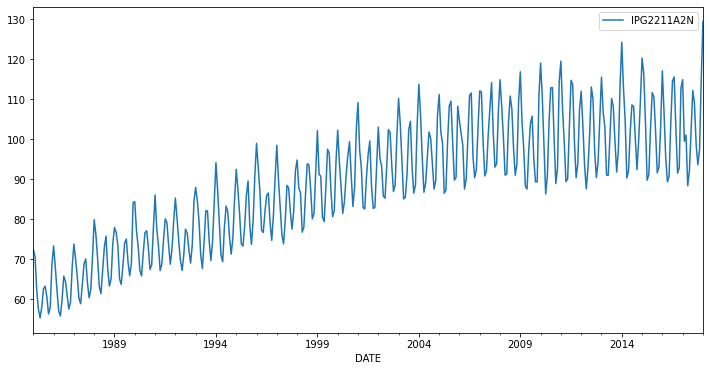

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

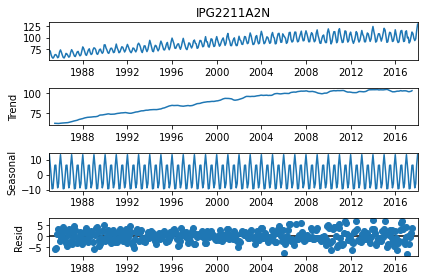

In [6]:
results = seasonal_decompose(df['IPG2211A2N'])
results.plot();

## Splitting into train and test data

In [7]:
len(df)

397

In [8]:
train = df.iloc[:324]
test = df.iloc[324:]

## Pre-processing the data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(            IPG2211A2N
 DATE                  
 1985-01-01     72.5052
 1985-02-01     70.6720
 1985-03-01     62.4502
 1985-04-01     57.4714
 1985-05-01     55.3151,
             IPG2211A2N
 DATE                  
 2017-09-01     98.6154
 2017-10-01     93.6137
 2017-11-01     97.3359
 2017-12-01    114.7212
 2018-01-01    129.4048)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.26787164],
       [0.23930506],
       [0.11118556],
       [0.03360141],
       [0.        ],
       [0.04324723],
       [0.11383466],
       [0.12362539],
       [0.0821141 ],
       [0.01558758]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

## Defining the Generator

In [14]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.26787164 0.23930506 0.11118556]
Predict this y: 
 [[0.03360141]]


In [16]:
X.shape

(1, 3, 1)

In [17]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

## Model Building

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
312/312 [==============================] - 3s 5ms/step - loss: 0.0340
Epoch 2/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0163
Epoch 3/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0133
Epoch 4/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0102
Epoch 5/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0060
Epoch 6/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0046
Epoch 7/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0033
Epoch 8/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0031
Epoch 9/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0031
Epoch 10/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0030
Epoch 11/50
312/312 [==============================] - 2s 6ms/step - loss: 0.0027
Epoch 12/50
312/312 [==============================] - 2s 5ms/step - loss: 0.0025
Epoch 13/50
312/312 [====

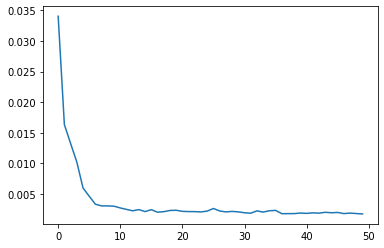

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
last_train_batch = scaled_train[-12:]

In [24]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [25]:
model.predict(last_train_batch)

array([[0.94069916]], dtype=float32)

In [26]:
scaled_test[0]

array([0.8827636])

## Prediction

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
test_predictions

[array([0.94069916], dtype=float32),
 array([0.8327465], dtype=float32),
 array([0.6584371], dtype=float32),
 array([0.5125181], dtype=float32),
 array([0.5483527], dtype=float32),
 array([0.75718063], dtype=float32),
 array([0.8991887], dtype=float32),
 array([0.86159945], dtype=float32),
 array([0.68311113], dtype=float32),
 array([0.5321694], dtype=float32),
 array([0.5739789], dtype=float32),
 array([0.7949438], dtype=float32),
 array([0.91858685], dtype=float32),
 array([0.83126783], dtype=float32),
 array([0.6556639], dtype=float32),
 array([0.5084756], dtype=float32),
 array([0.5440484], dtype=float32),
 array([0.7582767], dtype=float32),
 array([0.8884394], dtype=float32),
 array([0.83659446], dtype=float32),
 array([0.6654874], dtype=float32),
 array([0.518968], dtype=float32),
 array([0.559059], dtype=float32),
 array([0.7782946], dtype=float32),
 array([0.90196425], dtype=float32),
 array([0.824858], dtype=float32),
 array([0.65165067], dtype=float32),
 array([0.50560266], d

In [29]:
test.head()

,IPG2211A2N
DATE,
2012-01-01,111.9646
2012-02-01,103.3679
2012-03-01,93.5772
2012-04-01,87.5566
2012-05-01,92.7603


In [30]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[115.68249313],
       [108.75485824],
       [ 97.56891646],
       [ 88.20487329],
       [ 90.50448416],
       [103.90557693],
       [113.01864636],
       [110.60643505],
       [ 99.15232231],
       [ 89.46595379],
       [ 92.14899061],
       [106.32894959],
       [114.26348208],
       [108.65996757],
       [ 97.39095437],
       [ 87.94545394],
       [ 90.2282654 ],
       [103.9759149 ],
       [112.32883386],
       [109.00179278],
       [ 98.02135693],
       [ 88.61878068],
       [ 91.19153883],
       [105.26052301],
       [113.19676144],
       [108.24863058],
       [ 97.1334131 ],
       [ 87.7610888 ],
       [ 89.94725774],
       [103.70266435],
       [111.84609171],
       [108.1188444 ],
       [ 97.27340438],
       [ 88.01788419],
       [ 90.50802994],
       [104.42358559],
       [112.36944774],
       [107.80665149],
       [ 96.8410643 ],
       [ 87.56234547],
       [ 89.70143627],
       [103.36875307],
       [111.432716  ],
       [107

In [31]:
test['Predictions'] = true_predictions

<ipython-input-31-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


## Plotting actual vs fitted values

<AxesSubplot:xlabel='DATE'>

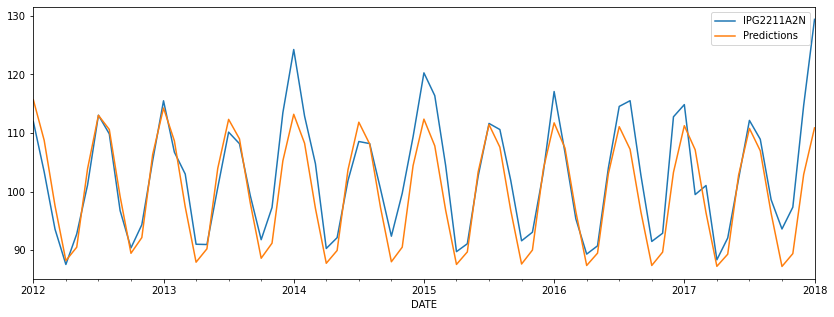

In [32]:
test.plot(figsize=(14,5))

## Calculating Mean Absolute Percentage Error

In [33]:
mape_lstm = mape(test['IPG2211A2N'],test['Predictions'])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 0.04 %
